<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_casia_cnn_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'casia-face-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4502072%2F7710309%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T222148Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D63e9d4210e230cac835476e827d8feb252647573aa6956d25737a1a3da52b7a473e3fdbe7b82c96e68971db2ddb6ca22ae18c018ceaa74d4febc534e9c7316e1028a53f2d1b54dbe082940661ae0138f20dbb1ba05603b5ab7eb4c5b5c946e834a42d226bc80372359c5c39db97c76e0a8c2a953cd452d5cf2456505a3e0470c22f8c2c7e0a4b69c72ce722a26232ee46eaad8009f62ccf1fcffb3a38a045e8b3d94a91c23770c2354150d5265447792467bac3814c51de2a5cd35bcc97fec90523ef71d0eca6c5ab496335290f5d1cd8d300cc3c998f180720ce18bab96bf8b98ade4f089df20b2cb707156c8395502a409eaf5ce2d71c1329a078f5c7837e0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 54767121 bytes downloaded
Downloaded and uncompressed: casia-face-dataset
Data source import complete.


In [13]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Set the dataset path to your Kaggle dataset location
dataset_path = '../input/casia-face-dataset/casia dataset'

In [14]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# Assuming 'dataset_path' is defined elsewhere and points to the dataset directory

def filter_top_classes(df, num_classes):
    # Group by 'person' and count the images for each
    image_counts = df.groupby('person').size().reset_index(name='counts')
    # Sort by counts and take the top 'num_classes' rows
    top_classes = image_counts.nlargest(num_classes, 'counts')['person']
    # Filter the original DataFrame to keep only the top classes
    return df[df['person'].isin(top_classes)]

# Read the dataset path and create tuples of (person, image_path)
people_data = os.listdir(dataset_path)
people = []
for item in people_data:
    person_images = os.listdir(os.path.join(dataset_path, item))
    for person_image in person_images:
        if person_image.endswith('.jpg'):  # Make sure to only read jpg files
            people.append((item, os.path.join(dataset_path, item, person_image)))

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Filter to only include the top N classes
num_classes_desired = 20  # Change this number to 30 or 40 as needed
people_df = filter_top_classes(people_df, num_classes_desired)

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
labels = people_df['person'].values
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded)

# Correct the size of the images to match the CNN input
im_size = 224

# Initialize lists to store the images and labels
images = []
labels = []

# Load and preprocess the images
for index, row in people_df.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(row['person'])

# Convert the lists to numpy arrays and preprocess
images = np.array(images)
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.2, random_state=1)

# Now you have train_x, test_x, train_y_onehot, test_y_onehot ready for training the model


In [15]:
num_classes = len(np.unique(labels))

In [16]:
im_shape=(im_size, im_size, 3)

In [17]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',#'categorical_crossentropy',
    # optimizer=Adam(lr=0.0001),
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 218, 218, 36)      5328      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 109, 109, 36)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 105, 105, 54)      48654     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 52, 52, 54)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 146016)            0         
                                                                 
 dense_4 (Dense)             (None, 2024)             

In [18]:
history = cnn_model.fit(
    train_x,
    train_y_onehot,
    epochs=10,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/10
51/51 [==============================] - 9s 152ms/step - loss: 3.2419 - accuracy: 0.0427 - val_loss: 2.9980 - val_accuracy: 0.0322
Epoch 2/10
51/51 [==============================] - 7s 137ms/step - loss: 2.9973 - accuracy: 0.0446 - val_loss: 3.0003 - val_accuracy: 0.0322
Epoch 3/10
51/51 [==============================] - 7s 138ms/step - loss: 2.9959 - accuracy: 0.0446 - val_loss: 3.0030 - val_accuracy: 0.0322
Epoch 4/10
51/51 [==============================] - 7s 140ms/step - loss: 2.9943 - accuracy: 0.0557 - val_loss: 3.0027 - val_accuracy: 0.0272
Epoch 5/10
51/51 [==============================] - 7s 138ms/step - loss: 2.9976 - accuracy: 0.0452 - val_loss: 3.0025 - val_accuracy: 0.0322
Epoch 6/10
51/51 [==============================] - 7s 139ms/step - loss: 2.9961 - accuracy: 0.0514 - val_loss: 3.0044 - val_accuracy: 0.0322
Epoch 7/10
51/51 [==============================] - 7s 138ms/step - loss: 2.9967 - accuracy: 0.0545 - val_loss: 3.0028 - val_accuracy: 0.0322
Epoch 

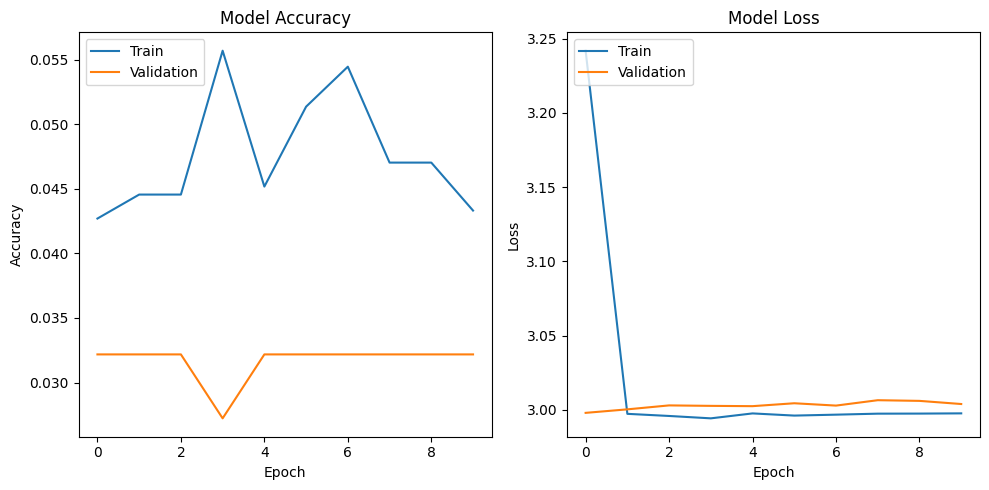

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Your pre-built and compiled model, assumed to be trained already.
predictions = cnn_model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# If you one-hot encoded the test labels for training,
# you need to reverse the one-hot encoding to get the original class indices.
actual_classes = np.argmax(test_y_onehot, axis=1)

# Inverse transform the predicted and actual class indices to their original names.
predicted_class_names = label_encoder.inverse_transform(predicted_classes)
actual_class_names = label_encoder.inverse_transform(actual_classes)

# Generate the classification report.
report = classification_report(actual_class_names, predicted_class_names, target_names=label_encoder.classes_)

print(report)

13/13 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

      000001       0.00      0.00      0.00        17
      000003       0.00      0.00      0.00        23
      000006       0.00      0.00      0.00        18
      000008       0.00      0.00      0.00        20
      000009       0.00      0.00      0.00        22
      000012       0.00      0.00      0.00        27
      000014       0.00      0.00      0.00        19
      000018       0.03      1.00      0.06        13
      000019       0.00      0.00      0.00        28
      000021       0.00      0.00      0.00        19
      000022       0.00      0.00      0.00        21
      000023       0.00      0.00      0.00        19
      000024       0.00      0.00      0.00        18
      000025       0.00      0.00      0.00        18
      000026       0.00      0.00      0.00        28
      000027       0.00      0.00      0.00        17
      000031       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
